#Team Members
Yomna Tarek Abdullah

Yomna.Soliman18@gmail.com

Dina Nabil Shaban

Dinabil@outlook.com

Ann Ahmed Hussien

Ann_ahmedhussien@yahoo.com


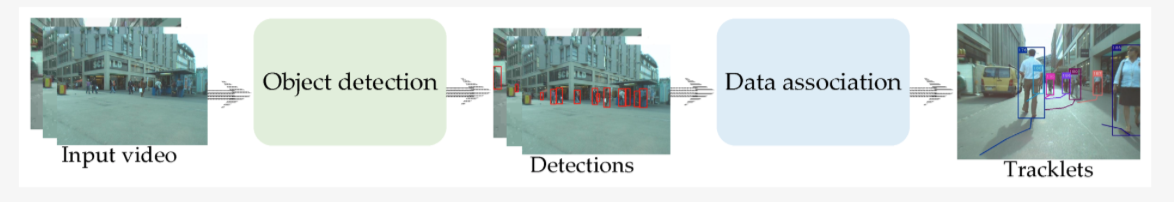

# **Multiple Object Tracking with PyTorch**

---





---
**Reference**


*   Object Detection with Faster R-CNN: https://www.learnopencv.com/faster-r-cnn-object-detection-with-pytorch/ 
*   Simple Online and Realtime Tracking (SORT) algorithm for object ID tracking: https://arxiv.org/abs/1602.00763


*   https://github.com/mannyray/sort/blob/master/python_implementation/hungarian.py





**Question**
: What is Multiple Object Tracking?
- Object tracking is one of the tasks in computer vision, which is detecting an object and searching for that object in a video or a series of images (actually both meaning the same thing). 
- Surveillance cameras in public places for spotting suspicious activities or crimes, and a computer system called 'Hawk-eye' for tracking the trajectory of the ball in various sports are typical examples of applying object tracking in a real life.


**Goals**


1. We will use MOT17Det Dataset
2. First part: Object Detection with **Faster R-CNN**
3. Second part: Multiple Object(ID) Tracking with  **Simple Online and Realtime Tracking (SORT)** algorithm



---




Input: A video with T frames
Output: Tracklets of the video

**Multi-object tracking (MOT)** is a significant and widespread research field in image processing and computer vision. The goal of the MOT task consists in predicting the complete tracklets of multiple objects in a video sequence. There are usually many challenges that degrade the performance of the algorithm in the tracking process, such as occlusion and similar objects

Multi-object tracking (MOT), which aims to assign and maintain a unique ID to each object of interest in a video sequence while predicting the location of all objects.

fair evaluation of multiple people tracking algorithms

**Object detection is a two-step process**
Find bounding boxes containing objects such that each bounding box has only one object.
Classify the image inside each bounding box and assign it a label.

**0. Preparation**


*   For your convenience, it is recommended to mount your Google Drive first.
*   Then create extra space for this tutorial in there.


---






In [3]:
from google.colab import drive
root = '/content/drive/'
drive.mount(root)

Mounted at /content/drive/


In [4]:
# Making Directory

import os 
from os.path import join

mot = "My Drive/Colab Notebooks/MOT/"   # a custom path. you can change if you want to
MOT_PATH = join(root,mot)
!mkdir "{MOT_PATH}"

mkdir: cannot create directory ‘/content/drive/My Drive/Colab Notebooks/MOT/’: File exists




---


**1. Dataset**


*   https://motchallenge.net/ : MOT17Det Dataset for Pedestrian Detection Challenge
*   We will only use MOT17-09 dataset for our task.


---






In [5]:
# Download MOT17Det Dataset

#!wget -P "{MOT_PATH}" /content/drive/MyDrive/Assignment5/MOT17Det.zip
!unzip /content/drive/MyDrive/Assignment5/MOT17Det.zip -d "{MOT_PATH}"

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/My Drive/Colab Notebooks/MOT/train/MOT17-02/img1/000323.jpg  
  inflating: /content/drive/My Drive/Colab Notebooks/MOT/train/MOT17-02/img1/000324.jpg  
  inflating: /content/drive/My Drive/Colab Notebooks/MOT/train/MOT17-02/img1/000325.jpg  
  inflating: /content/drive/My Drive/Colab Notebooks/MOT/train/MOT17-02/img1/000326.jpg  
  inflating: /content/drive/My Drive/Colab Notebooks/MOT/train/MOT17-02/img1/000327.jpg  
  inflating: /content/drive/My Drive/Colab Notebooks/MOT/train/MOT17-02/img1/000328.jpg  
  inflating: /content/drive/My Drive/Colab Notebooks/MOT/train/MOT17-02/img1/000329.jpg  
  inflating: /content/drive/My Drive/Colab Notebooks/MOT/train/MOT17-02/img1/000330.jpg  
  inflating: /content/drive/My Drive/Colab Notebooks/MOT/train/MOT17-02/img1/000331.jpg  
  inflating: /content/drive/My Drive/Colab Notebooks/MOT/train/MOT17-02/img1/000332.jpg  
  inflating: /content/drive/My Drive/Colab Notebo

In [6]:
# Remove unwanted data for drive volume issue (optional)

!cd "{MOT_PATH}";rm -rf test
!cd "{MOT_PATH}";rm -rf train/MOT17-02;rm -rf train/MOT17-09;rm -rf train/MOT17-05
!cd "{MOT_PATH}";rm -rf train/MOT17-10;rm -rf train/MOT17-11;rm -rf train/MOT17-13

In [7]:
import sys

motdata = join(MOT_PATH,'train/MOT17-04/img1/')
sys.path.append(motdata)

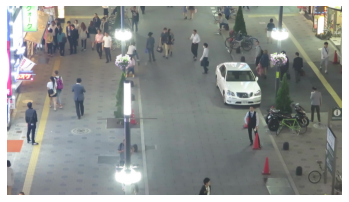

In [8]:
# Example: Original picture before detection

import matplotlib.pylab as plt
import cv2

list_motdata = os.listdir(motdata)  
list_motdata.sort()

img_ex_path = motdata + list_motdata[0]
img_ex_origin = cv2.imread(img_ex_path)
img_ex = cv2.cvtColor(img_ex_origin, cv2.COLOR_BGR2RGB)

plt.imshow(img_ex)
plt.axis('off')
plt.show()




---


**2. Object Detection with Faster R-CNN**

*  We will use a pretrained Faster R-CNN model using ResNet50 as a backbone with FPN.

we are going to use expects the input image tensor to be in the form [n, c, h, w] and have a min size of 800px, where:


n is the number of images

c is the number of channels , for RGB images 

its 3 h is the height of the image

w is the width of the image




---




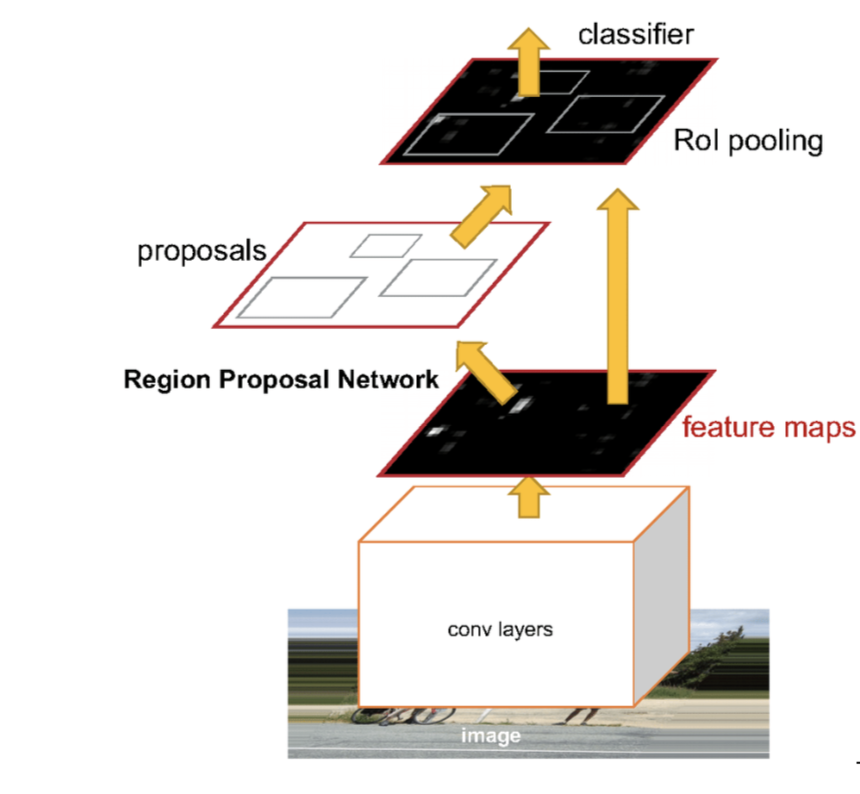

The model will return
Bounding boxes [x0, y0, x1, y1] all the predicted classes of shape (N,4) 

where N is the number of classes predicted by the model to be present in the image.

Labels of all the predicted classes.

Scores of each of the predicted label.

In [9]:
# Import required packages/modules first

from PIL import Image
import numpy as np
import torch
import torchvision
from torchvision import transforms as T

In [24]:
# Download the pretrained Faster R-CNN model from torchvision
# Download a pretrained Resnet50 Faster R-CNN model with pretrained weights.

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [11]:
# Download a pretrained Resnet50 Faster R-CNN model with pretrained weights.
# Define the class names given by PyTorch's official Docs

COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

#We can see some N/A’s in the list,
#as a few classes were removed in the later papers. We will go with the list given by PyTorch.

# Prediction of the model

Image is obtained from the image path :

1.   The image is converted to image tensor using PyTorch’s Transforms
2.   The image is passed through the model to get the predictions

3. Class, box coordinates are obtained, but only prediction score > threshold are chosen.





In [12]:
# Defining a function for get a prediction result from the model

def get_prediction(img_path, threshold):
  img = Image.open(img_path) # Load the image
  transform = T.Compose([T.ToTensor()]) # Defing PyTorch Transform
  img = transform(img) # Apply the transform to the image

  pred = model([img]) # Pass the image to the model
  pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())] # Get the Prediction Score

  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())] # Bounding boxes
  pred_score = list(pred[0]['scores'].detach().numpy())
  
  pred_t = [pred_score.index(x) for x in pred_score if x > threshold][-1] # Get list of index with score greater than threshold.
  pred_boxes = pred_boxes[:pred_t+1]
  pred_class = pred_class[:pred_t+1]
  return pred_boxes, pred_class




# Pipeline for Object Detection

Next we will define a pipeline to get the image path and get the output image



1.   prediction is obtained from get_prediction method
2. for each prediction, bounding box is drawn and text is written with opencv
3. the final image is displayed



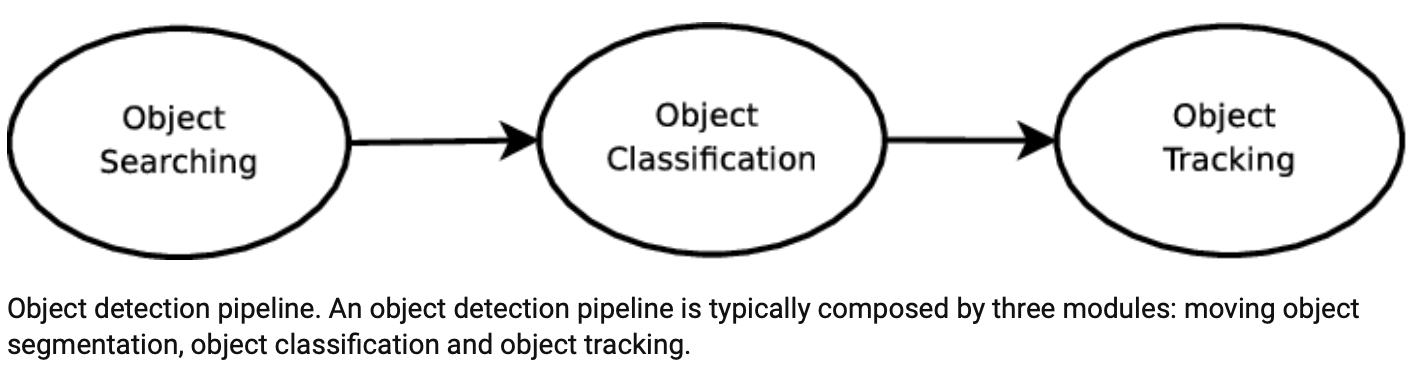

In [13]:
# Defining api function for object detection

def object_detection_api(img_path, threshold=0.5, rect_th=3, text_size=1.5, text_th=3):
 
  boxes, pred_cls = get_prediction(img_path, threshold) # Get predictions

  
  img = cv2.imread(img_path) # Read image with cv2
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB
  for i in range(len(boxes)):
    cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th) # Draw Rectangle with the coordinates
    cv2.putText(img,pred_cls[i], boxes[i][0],  cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th) # Write the prediction class
  
  
  plt.figure(figsize=(15,20)) # display the output image
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.show()

# Inference


Now lets use the API pipleine which we built to detect object in some images. The pretrained Model takes around 8 seconds for inference in CPU and 0.15 second in NVIDIA GTX 1080 Ti GPU.

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


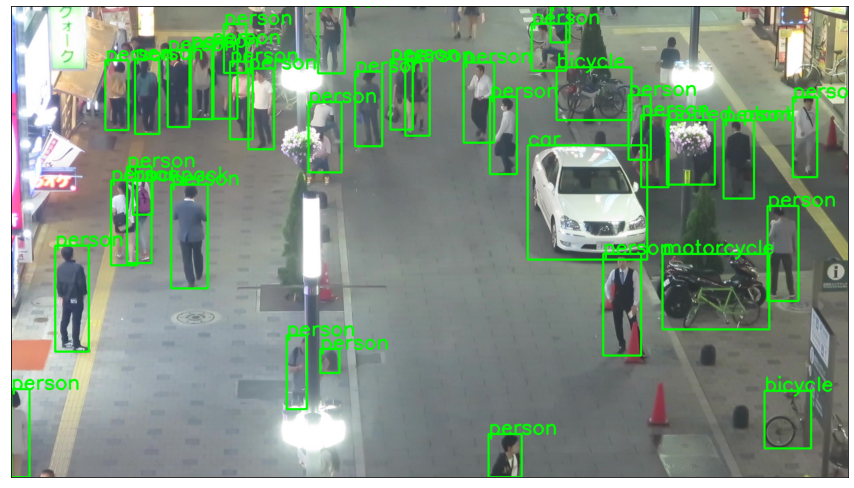

In [14]:
# Example: After detection of MOT16-03 :: Raw Sequence Video
object_detection_api(img_ex_path,threshold=0.8)





*   The picture above is an example of applying Detection Network (in our case, Faster R-CNN).
*   Since the purpose of dataset we are using is 'tracking', you can see that most of the detected classes are 'person'.
*   We need a prediction result (bbs offset, class label, pred scores) for all the images.




# SORT Algorithm

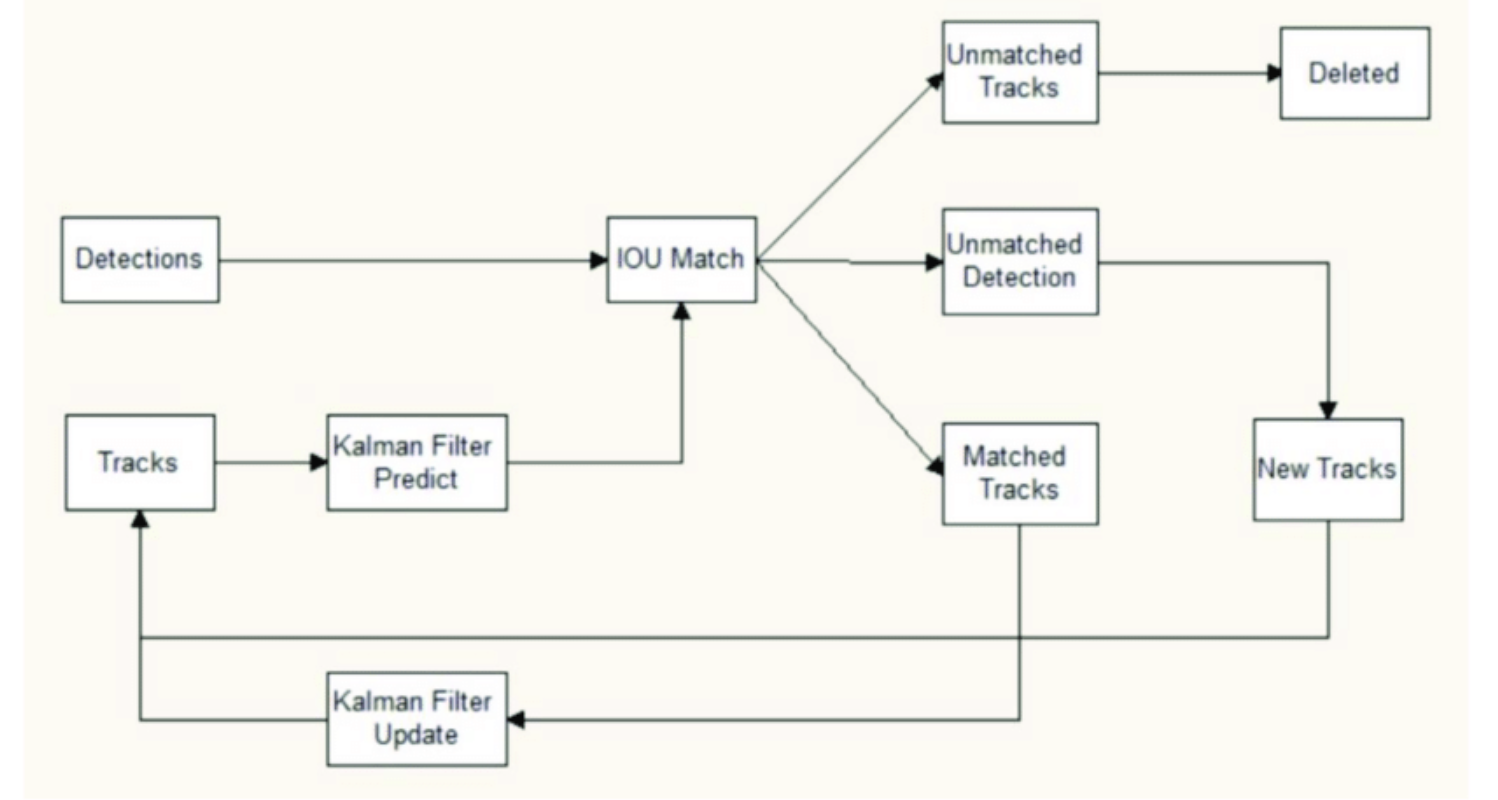

Locate all objects of interest from the video sequence. Then, the feature information of each object is extracted in the data association process, and the same objects are associated according to the metrics (e.g., appearance feature and motion feature) defined on the feature. Finally, by associating the same object in different video frames, a continuously updated tracklet set is formed.


A simple online and realtime tracking algorithm for 2D multiple object tracking in video sequences.

It is designed for online tracking applications where only past and current frames are available and the method produces object identities on the fly.

SORT uses kalman filter for object tracking without using ego-motion information. The correction information is from associating objects in two adjcent frames.


For example, A is detected within frame t, B is detected within frame t+1, and A and B are associated as the same object using some criteria like IOU (intersection over union). So the Kalman filter can use B’s __cpLocation in frame t+1 as a new measurement for A to update the states.




From the above process, you can see association plays a critical role. Not associated means lost. IOU is not a good criterion, as it lays a big burden on the initial states of kalman filter, especially when the objects are small.



```
# This is formatted as code
```



---


**3. Object ID Tracking with SORT**


*   Simple Online and Realtime Tracking (SORT) algorithm for object ID tracking 

---



Steps:

Step 1. The detection generation: to produce the **detections** for each video frame.
Step 2. The **appearance feature extraction**: The appearance features of **each detection** are extracted through a *convolutional neural network*.

Step 3. The tracklet location prediction: We can obtain the **predicted location of every tracklet** in the next frame t+1 by utilizing the *Kalman filter.*
Step 4. The matching cascade: We calculate the appearance feature similarity and location distance **between the confirmed tracklets and detections**. 
After that, the *association results* of the confirmed tracklets and detections are obtained through the *Hungarian algorithm.*

Step 5. The *IOU matching*: We compute the intersection-over-union (IOU) between **the detection boxes and predicted bounding boxes of candidate tracklets.** 
After that, the association results of the candidate tracklets and detections are obtained through the Hungarian algorithm.

Step 6. The motion state updating: We** update the motion state of the tracklets by the Kalman filter and the motion prediction model**. Then, we initialize new tracklets for unassociated detections.

In [15]:
# Git clone: SORT Algorithm

!cd "{MOT_PATH}";git clone https://github.com/abewley/sort.git
  
sort = join(MOT_PATH,'sort/')
sys.path.append(sort)

fatal: destination path 'sort' already exists and is not an empty directory.


In [16]:
# requirement for sort
!cd "{sort}";pip install -r requirements.txt

     |████████████████████████████████| 177 kB 5.5 MB/s 
     |████████████████████████████████| 12.5 MB 33.8 MB/s 
     |████████████████████████████████| 1.5 MB 47.3 MB/s 
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110474 sha256=a5a8b4ca4c95eeb67669ab9de1ef9f73c94d7054e7e6060d4cb8ae01e336e7bf
  Stored in directory: /root/.cache/pip/wheels/ce/e0/ee/a2b3c5caab3418c1ccd8c4de573d4cbe13315d7e8b0a55fbc2
  Created wheel for lap: filename=lap-0.4.0-cp37-cp37m-linux_x86_64.whl size=1590180 sha256=9a85bfc319f8af53e8f84622a5ebcc26e87c543de90763f273269ce334bb3562
  Stored in directory: /root/.cache/pip/wheels/b1/0b/e3/ef9daf1b5547b56389e42c80c3100f1e6479bf5fd00fd9d6ba
Successfully built filterpy lap
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.18.3
    Uninstalling scikit-image-0.18.3:
      Successfully uninstalled scikit-image-0.18.3
ERROR: pip's dependency resolver does not currently take into account all the packages th

In [20]:
# Optional: if error occurs, you might need to re-install scikit-image and imgaug

!pip uninstall scikit-image
!pip uninstall imgaug
!pip install imgaug
!pip install -U scikit-image

import skimage
print(skimage.__version__)

Found existing installation: scikit-image 0.19.1
Uninstalling scikit-image-0.19.1:
  Would remove:
    /usr/local/bin/skivi
    /usr/local/lib/python3.7/dist-packages/doc/ext/*
    /usr/local/lib/python3.7/dist-packages/scikit_image-0.19.1.dist-info/*
    /usr/local/lib/python3.7/dist-packages/scikit_image.libs/libgomp-f7e03b3e.so.1.0.0
    /usr/local/lib/python3.7/dist-packages/skimage/*
Proceed (y/n)? y
  Successfully uninstalled scikit-image-0.19.1
Found existing installation: imgaug 0.4.0
Uninstalling imgaug-0.4.0:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/imgaug-0.4.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/imgaug/*
Proceed (y/n)? y
  Successfully uninstalled imgaug-0.4.0
  Using cached imgaug-0.4.0-py2.py3-none-any.whl (948 kB)
  Using cached scikit_image-0.19.1-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (13.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour

0.19.1


In [18]:
# Detection information on all the images is well-refined as a json file, which is available at our course git repo

!cd "{MOT_PATH}";git clone https://github.com/mlvlab/COSE474.git

fatal: destination path 'COSE474' already exists and is not an empty directory.


In [21]:
import json
import collections
from pprint import pprint

from sort import*

jsonpath = join(MOT_PATH,'COSE474/3_MOT_detinfo.json')

with open(jsonpath) as data_file:    
   data = json.load(data_file)
odata = collections.OrderedDict(sorted(data.items()))

/usr/local/lib/python3.7/dist-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [22]:
# Let's check out downloaded json file

pprint(odata)

Streaming output truncated to the last 5000 lines.
                'scores': 0.9063880443572998},
               {'bbox': [34.13352966308594,
                         355.93682861328125,
                         85.53865051269531,
                         401.1189270019531],
                'labels': 68,
                'scores': 0.8869121670722961},
               {'bbox': [1317.8665771484375,
                         566.4204711914062,
                         1369.163818359375,
                         642.6348266601562],
                'labels': 27,
                'scores': 0.8799705505371094},
               {'bbox': [1227.9986572265625,
                         579.244873046875,
                         1272.51025390625,
                         648.2922973632812],
                'labels': 27,
                'scores': 0.7431402206420898}]),
             ('000459.jpg',
              [{'bbox': [76.42948150634766,
                         150.27622985839844,
                    



---



*   For each image, bbs offset, class label, pred scores are all annotated.
*   Labels are annotated as a number - not a word, and for further information, go to the website below.
* https://tech.amikelive.com/node-718/what-object-categories-labels-are-in-coco-dataset/ 



---



In [ ]:
img_path = motdata    # img root path

# Making new directory for saving results
save_path = join(MOT_PATH,'save/')
!mkdir "{save_path}"

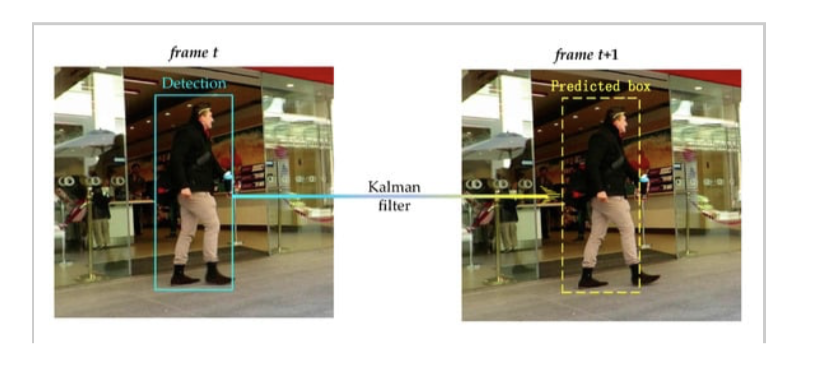

# Tracker

where the results is an array of sort.trackedObject with main properties:

position


velocity


name

objectType

width

height

In [ ]:
mot_tracker = Sort()      # Tracker using SORT Algorithm

A lot of the algorithm's parameters are set by default in the object's contructor (as seen in sort.py):

def __init__(self,sensorNoise=np.array([[1,0],[0,1]]),processNoise=np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]]),pr

You can specify all of the parmaters or some of them like:

tracker = sort.tracker(sensorNoise=np.array([[2,0],[0,2]]))
Alternatively, you can set certain parameters via method:

tracker = sort.tracker()
tracker.set_sensorNoise(np.array([[2,0],[0,2]]))

In [ ]:
for key in odata.keys():   
    arrlist = []
    det_img = cv2.imread(os.path.join(img_path, key))
    overlay = det_img.copy()
    det_result = data[key] 
    
    for info in det_result:
        bbox = info['bbox']
        labels = info['labels']
        scores = info['scores']
        templist = bbox+[scores]
        
        if labels == 1: # label 1 is a person in MS COCO Dataset
            arrlist.append(templist)
            
    track_bbs_ids = mot_tracker.update(np.array(arrlist))
    
    mot_imgid = key.replace('.jpg','')
    newname = save_path + mot_imgid + '_mot.jpg'
    print(mot_imgid)
    
    for j in range(track_bbs_ids.shape[0]):  
        ele = track_bbs_ids[j, :]
        x = int(ele[0])
        y = int(ele[1])
        x2 = int(ele[2])
        y2 = int(ele[3])
        track_label = str(int(ele[4])) 
        cv2.rectangle(det_img, (x, y), (x2, y2), (0, 255, 255), 4)
        cv2.putText(det_img, '#'+track_label, (x+5, y-10), 0,0.6,(0,255,255),thickness=2)
        
    cv2.imwrite(newname,det_img)
    #log their locations. To retrieve the locations


---
It's all done!


*   Finally, you can get a sequence of image with each Tracking ID for every detected person. 
*   Check '3_MOT_result.gif' for whole demo experience.
In the crowded scene with a large number of occlusions.



---




The MOT-16 contains seven testing video sequences in total. Compared to the MOT-15, the MOT-16 is a more challenging dataset. The scenarios of the videos in MOT-16 are more crowded and more complex. In addition to the challenges of the MOT-15, there still exists the following challenges in MOT-16 video sequences:
Different viewpoints: Each video sequence has a different viewpoint owing to the different heights of the camera. Videos from multiple perspectives increase the difficulty of object detection and feature extraction.
Varying weather conditions: A sunny weather video may contain some shadows, while the videos with dark or cloudy weather have lower visibility, making pedestrian detection and tracking more difficult.

In [23]:
from ipywidgets import Image
from IPython import display
animatedGif = "/content/drive/MyDrive/Colab Notebooks/MOT/COSE474/SORT_Result.gif" #path relative to your notebook
file = open(animatedGif , "rb")
image = file.read()
progress= Image(
    value=image,
    format='gif',
    width=700,
    height=700)
display.display(progress)

Image(value=b'GIF89a\xf4\x01\x1a\x01\xf7\x00\x00\x00\xff\x00\x08A\x04\n\x1d\r\x11c\x14\x12\x19K\x1ff< >-%*c+$s…

In [ ]:
# convert images to video

import cv2
import numpy as np
import glob

img_array = []
for filename in glob.glob('/content/drive/MyDrive/Colab Notebooks/MOT/save/*.jpg'):
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)


out = cv2.VideoWriter('/content/drive/MyDrive/Colab Notebooks/MOT/save/project.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

Focusing on the problem that it is difficult to predict the location of occluded objects in existing multi-object tracking methods,

In [ ]:
from PIL import Image
import glob
 
# Create the frames
frames = []
imgs = glob.glob("/content/drive/MyDrive/Colab Notebooks/MOT/save/*.jpg")
for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)
 
# Save into a GIF file that loops forever
frames[0].save('jpg_to_gif.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=300, loop=0)

In [ ]:
a = []
while 1:
    a.append("1")